Usando dispositivo: cpu

--- Iniciando Sección 1: Carga y Análisis Exploratorio de Datos ---
Archivos cargados exitosamente.
Error: No se pudo identificar la columna de casos en 'df_train.csv'. Asegúrate de que exista.

Iniciando preprocesamiento de datos...
Preprocesamiento completado. El código ya no busca la columna 'city'.


C:\Users\cahoyos\AppData\Local\Temp\ipykernel_11968\3502599818.py:69: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  full_df_processed.interpolate(method='linear', inplace=True, limit_direction='both')
C:\Users\cahoyos\AppData\Local\Temp\ipykernel_11968\3502599818.py:71: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_df_processed.fillna(method='bfill', inplace=True)
C:\Users\cahoyos\AppData\Local\Temp\ipykernel_11968\3502599818.py:72: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_df_processed.fillna(method='ffill', inplace=True)


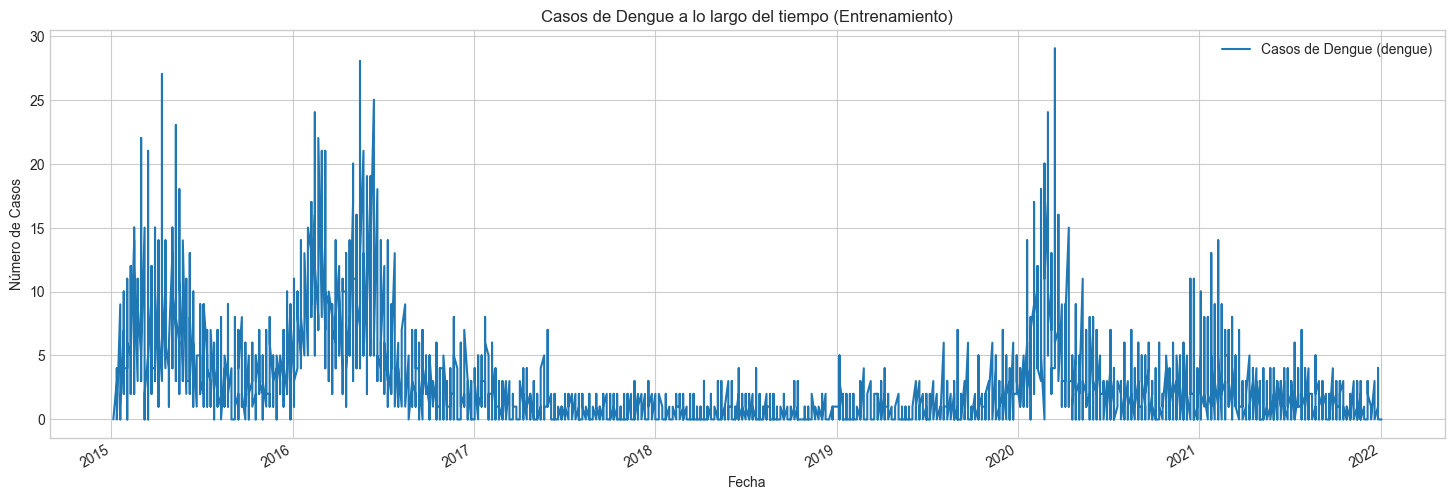

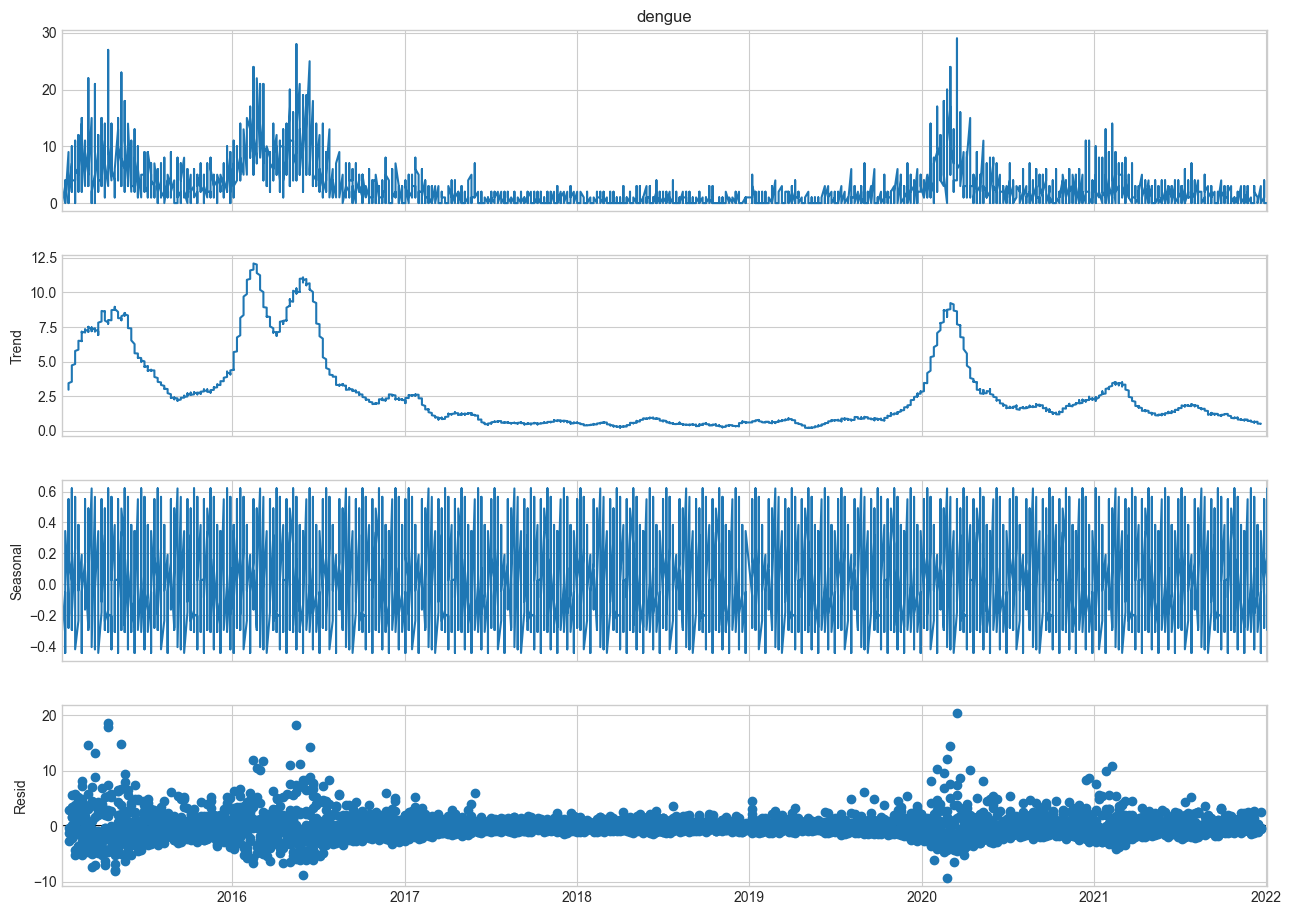

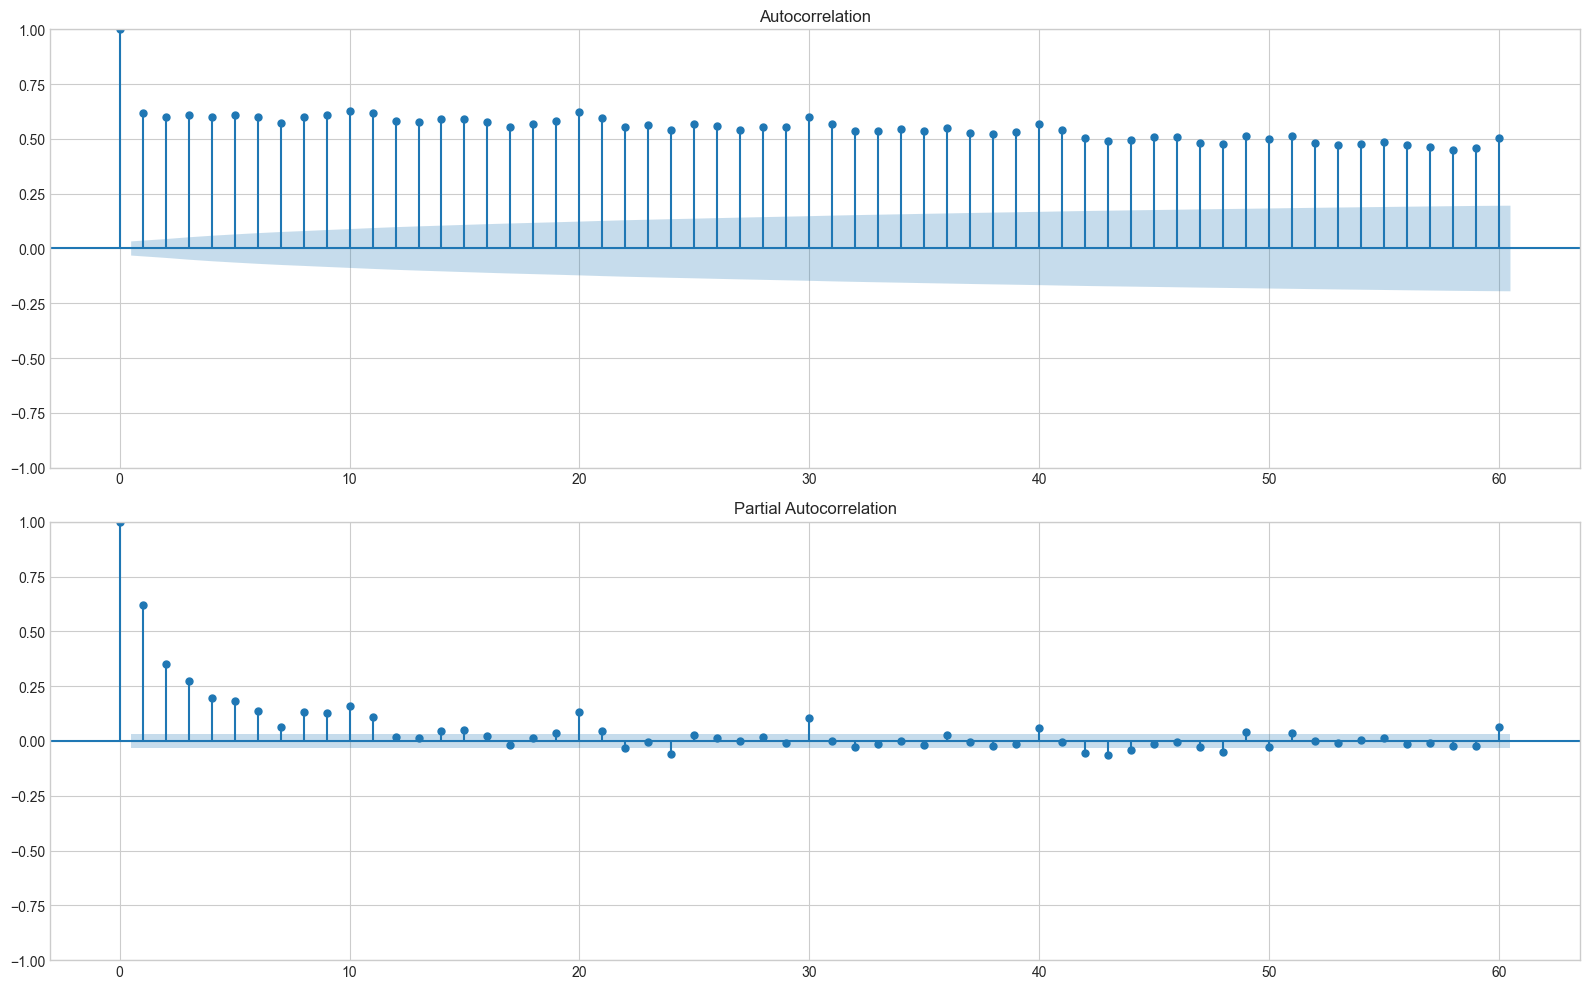

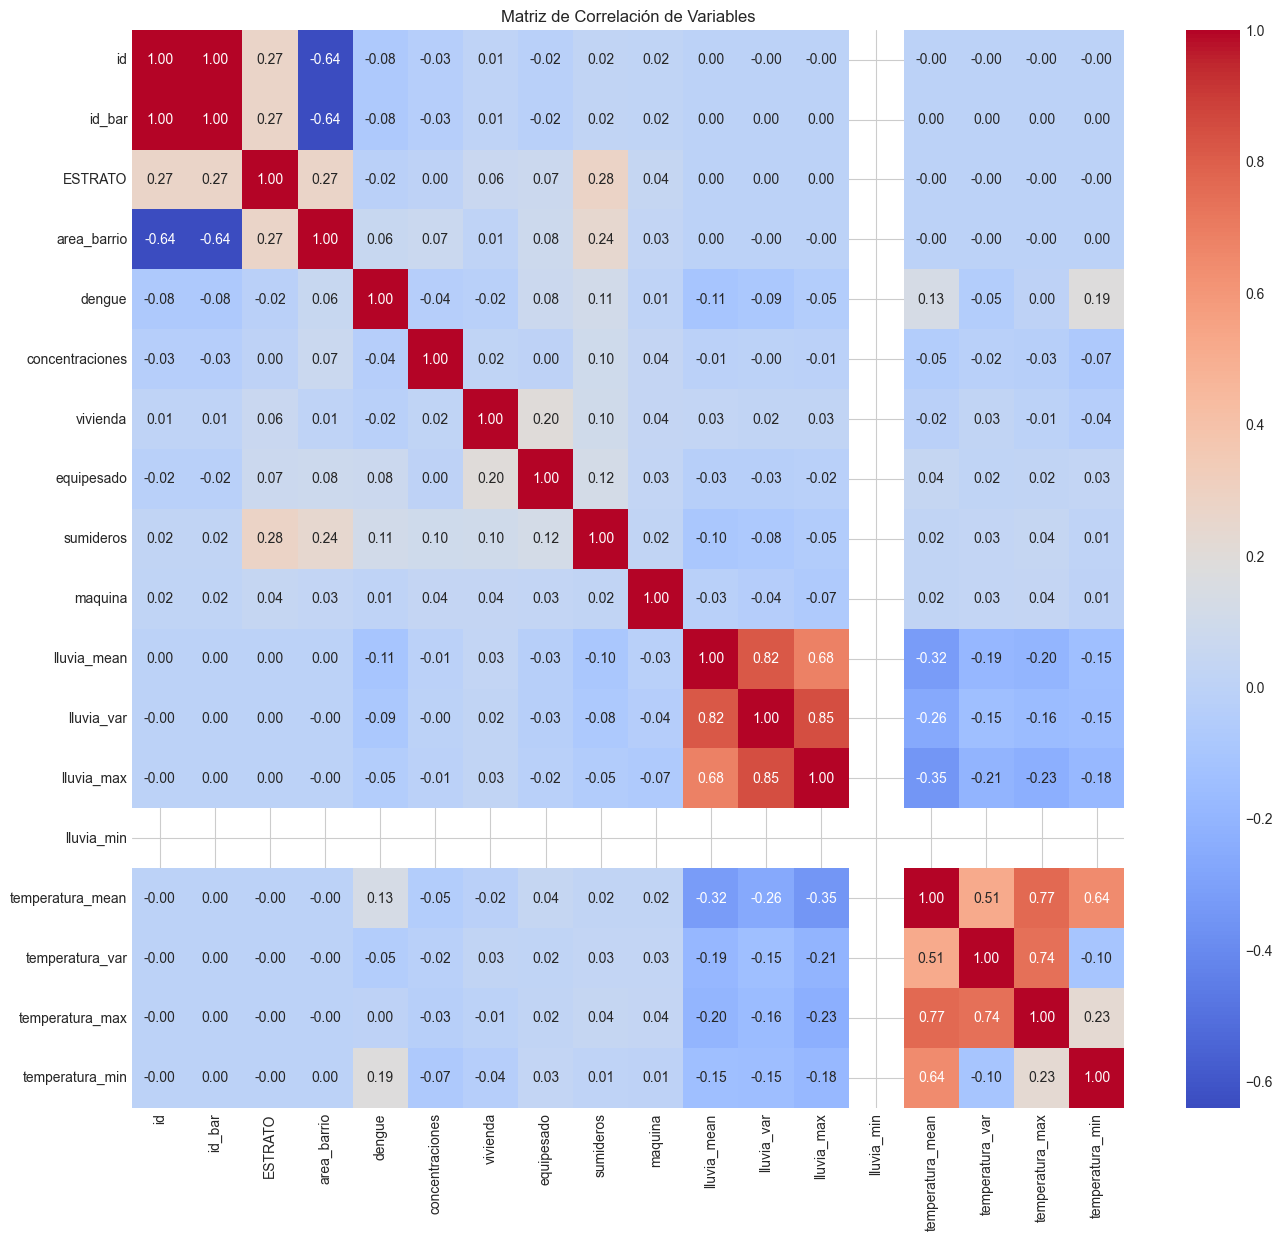

[I 2025-06-17 17:21:04,403] A new study created in memory with name: no-name-ad997ed8-4d06-434e-9b6f-440380038ac3



--- Iniciando Sección 2: Modelo LSTM y Optimización de Hiperparámetros ---

Características seleccionadas para el modelo (17): ['id', 'id_bar', 'ESTRATO', 'area_barrio', 'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var', 'lluvia_max', 'lluvia_min', 'temperatura_mean', 'temperatura_var', 'temperatura_max', 'temperatura_min']

Forma de tensores de entrenamiento: X=torch.Size([2934, 12, 17]), y=torch.Size([2934, 1])

Iniciando optimización con Optuna (20 trials)...


[I 2025-06-17 17:22:02,085] Trial 0 finished with value: 0.014290826841412732 and parameters: {'n_layers': 2, 'hidden_size': 169, 'dropout': 0.31445346309658273, 'lr': 0.005844520733018318, 'batch_size': 64}. Best is trial 0 with value: 0.014290826841412732.
[I 2025-06-17 17:22:19,751] Trial 1 finished with value: 0.0055317390554895 and parameters: {'n_layers': 2, 'hidden_size': 34, 'dropout': 0.26217340771940206, 'lr': 0.00018195831554048165, 'batch_size': 64}. Best is trial 1 with value: 0.0055317390554895.
[I 2025-06-17 17:23:09,455] Trial 2 finished with value: 0.018054462642834078 and parameters: {'n_layers': 1, 'hidden_size': 185, 'dropout': 0.4441708754695828, 'lr': 0.007257325943874858, 'batch_size': 16}. Best is trial 1 with value: 0.0055317390554895.
[I 2025-06-17 17:23:22,706] Trial 3 finished with value: 0.006725614114354054 and parameters: {'n_layers': 1, 'hidden_size': 80, 'dropout': 0.1615714228540108, 'lr': 0.0018330028710675705, 'batch_size': 64}. Best is trial 1 with 


Optimización completada. Mejores hiperparámetros: {'n_layers': 2, 'hidden_size': 34, 'dropout': 0.26217340771940206, 'lr': 0.00018195831554048165, 'batch_size': 64}

--- Iniciando Sección 3: Entrenamiento Final y Pronóstico ---
Entrenando el modelo final por 60 épocas...
Epoch [10/60], Loss: 0.008671
Epoch [20/60], Loss: 0.004258
Epoch [30/60], Loss: 0.003050
Epoch [40/60], Loss: 0.049463
Epoch [50/60], Loss: 0.006515
Epoch [60/60], Loss: 0.005508
Entrenamiento final completado.

Generando pronósticos...
Pronósticos generados.

Archivo de submission 'output/submission.csv' creado.
          id  dengue
0  4_2022_01       0
1  5_2022_01       0
2  3_2022_01       0
3  8_2022_01       1
4  9_2022_01       1


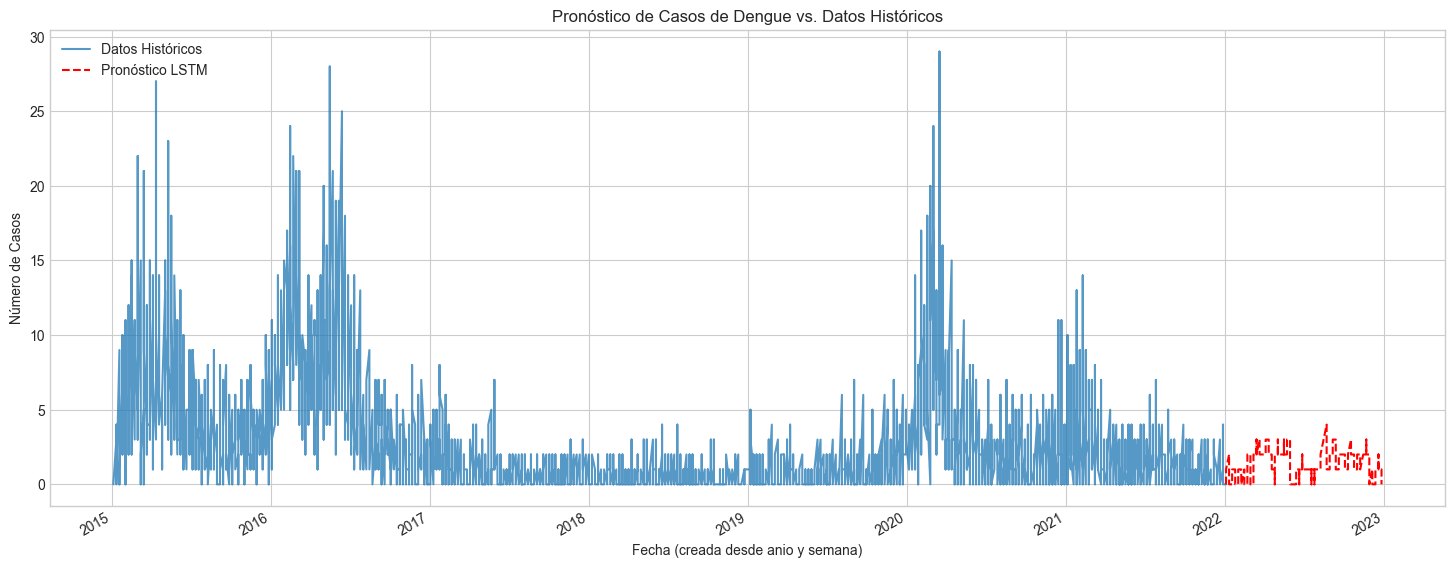


--- Proceso Finalizado ---


: 

In [ ]:
# ==============================================================================
# SECCIÓN 0: CONFIGURACIÓN INICIAL E IMPORTACIÓN DE LIBRERÍAS
# ==============================================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import optuna

# --- Configuración de Gráficos y PyTorch ---
plt.style.use('seaborn-v0_8-whitegrid')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
os.makedirs('output', exist_ok=True)

# ==============================================================================
# SECCIÓN 1: ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# ==============================================================================
print("\n--- Iniciando Sección 1: Carga y Análisis Exploratorio de Datos ---")

# --- 1.1 Carga de Datos ---
DATA_PATH = '../../Datos/'
try:
    df_train_raw = pd.read_csv(f'{DATA_PATH}df_train.csv')
    df_test_raw = pd.read_csv(f'{DATA_PATH}df_test.csv')
    sample_submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')
    print("Archivos cargados exitosamente.")
    # Identificar el nombre real de la columna de casos
    TARGET = [col for col in df_train_raw.columns if 'casos' in col.lower()][0]
    print(f"Variable objetivo identificada como: '{TARGET}'")
except FileNotFoundError:
    print(f"Error: No se encontraron los archivos en la ruta '{DATA_PATH}'.")
    exit()
except IndexError:
    print("Error: No se pudo identificar la columna de casos en 'df_train.csv'. Asegúrate de que exista.")
    exit()


# --- 1.2 Preprocesamiento de Datos (Fechas, Categorías, Nulos) ---
print("\nIniciando preprocesamiento de datos...")
train_len = len(df_train_raw)
full_df_raw = pd.concat([df_train_raw, df_test_raw], axis=0, ignore_index=True)

# Manejo de la variable categórica 'estrato'
if 'estrato' in full_df_raw.columns:
    print("Codificando la variable categórica 'estrato'...")
    full_df_processed = pd.get_dummies(full_df_raw, columns=['estrato'], drop_first=True)
else:
    full_df_processed = full_df_raw.copy()

# Crear el índice de tiempo usando 'anio' y 'semana'
full_df_processed['date'] = pd.to_datetime(
    full_df_processed['anio'].astype(str) + full_df_processed['semana'].astype(str) + '-1',
    format='%Y%W-%w'
)

# Ordenar los datos cronológicamente
full_df_processed.sort_values(by='date', inplace=True)
full_df_processed.set_index('date', inplace=True)

# Rellenar valores NaN usando interpolación lineal
full_df_processed.interpolate(method='linear', inplace=True, limit_direction='both')
# Rellenar cualquier valor restante al inicio o final
full_df_processed.fillna(method='bfill', inplace=True)
full_df_processed.fillna(method='ffill', inplace=True)

# Separar de nuevo en entrenamiento y prueba
df_train = full_df_processed.iloc[:train_len].copy()
df_test = full_df_processed.iloc[train_len:].copy()
print("Preprocesamiento completado. El código ya no busca la columna 'city'.")


# --- 1.3 Análisis de la Serie de Tiempo del Target ---
plt.figure(figsize=(18, 6))
df_train[TARGET].plot(label=f'Casos de Dengue ({TARGET})')
plt.title('Casos de Dengue a lo largo del tiempo (Entrenamiento)')
plt.xlabel('Fecha')
plt.ylabel('Número de Casos')
plt.legend()
plt.savefig('output/eda_timeseries_plot.png')
plt.show()

# Descomposición estacional
decomposition = seasonal_decompose(df_train[TARGET], model='additive', period=52)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.savefig('output/eda_decomposition.png')
plt.show()

# ACF y PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
plot_acf(df_train[TARGET], lags=60, ax=ax1)
plot_pacf(df_train[TARGET], lags=60, ax=ax2)
plt.tight_layout()
plt.savefig('output/eda_acf_pacf.png')
plt.show()

# --- 1.4 Análisis de Correlación ---
plt.figure(figsize=(16, 14))
corr_cols = [col for col in df_train.columns if col not in ['anio', 'semana']]
correlation_matrix = df_train[corr_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables')
plt.savefig('output/eda_correlation_matrix.png')
plt.show()


# ==============================================================================
# SECCIÓN 2: MODELO LSTM CON PYTORCH Y OPTIMIZACIÓN CON OPTUNA
# ==============================================================================
print("\n--- Iniciando Sección 2: Modelo LSTM y Optimización de Hiperparámetros ---")

# --- 2.1 Preparación de Datos para LSTM ---
# Seleccionar features excluyendo columnas de tiempo y el target
features = [col for col in df_train.columns if col not in [TARGET, 'anio', 'semana']]
# Si 'estrato' fue codificado, la columna original ya no existe en df_train
if 'estrato' in features:
    features.remove('estrato')

print(f"\nCaracterísticas seleccionadas para el modelo ({len(features)}): {features}")
num_features = len(features)

# Escalar las características
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

df_train_scaled[features] = scaler_features.fit_transform(df_train[features])
df_train_scaled[TARGET] = scaler_target.fit_transform(df_train[[TARGET]])
df_test_scaled[features] = scaler_features.transform(df_test[features])

def create_sequences(input_data, target_data, sequence_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length):
        X.append(input_data[i:(i + sequence_length)])
        y.append(target_data[i + sequence_length])
    return np.array(X), np.array(y)

SEQUENCE_LENGTH = 12
X_train_data = df_train_scaled[features].values
y_train_data = df_train_scaled[TARGET].values
X_seq, y_seq = create_sequences(X_train_data, y_train_data, SEQUENCE_LENGTH)

split_index = int(len(X_seq) * 0.8)
X_train, X_val = X_seq[:split_index], X_seq[split_index:]
y_train, y_val = y_seq[:split_index], y_seq[split_index:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

print(f"\nForma de tensores de entrenamiento: X={X_train_tensor.shape}, y={y_train_tensor.shape}")

# --- 2.2 Definición del Modelo LSTM ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# --- 2.3 Optimización con Optuna ---
def objective(trial):
    params = {
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'hidden_size': trial.suggest_int('hidden_size', 32, 256, log=True),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64])
    }
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=params['batch_size'], shuffle=False)
    model = LSTMModel(num_features, params['hidden_size'], params['n_layers'], 1, params['dropout']).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    epochs = 30
    for _ in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(X_batch), y_batch)
            loss.backward()
            optimizer.step()
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            val_loss += criterion(model(X_batch), y_batch).item()
    return val_loss / len(val_loader)

N_TRIALS = 20
print(f"\nIniciando optimización con Optuna ({N_TRIALS} trials)...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS, timeout=600)
best_params = study.best_params
print(f"\nOptimización completada. Mejores hiperparámetros: {best_params}")

# ==============================================================================
# SECCIÓN 3: ENTRENAMIENTO FINAL Y GENERACIÓN DE PRONÓSTICOS
# ==============================================================================
print("\n--- Iniciando Sección 3: Entrenamiento Final y Pronóstico ---")

# --- 3.1 Entrenamiento del Modelo Final ---
X_final_train_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)
y_final_train_tensor = torch.tensor(y_seq, dtype=torch.float32).view(-1, 1).to(device)
final_train_loader = DataLoader(TensorDataset(X_final_train_tensor, y_final_train_tensor), batch_size=best_params['batch_size'], shuffle=True)
final_model = LSTMModel(num_features, best_params['hidden_size'], best_params['n_layers'], 1, best_params['dropout']).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['lr'])

epochs = 10#60
print(f"Entrenando el modelo final por {epochs} épocas...")
for epoch in range(epochs):
    final_model.train()
    for X_batch, y_batch in final_train_loader:
        optimizer.zero_grad()
        loss = criterion(final_model(X_batch), y_batch)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')
print("Entrenamiento final completado.")

# --- 3.2 Generación de Pronósticos ---
print("\nGenerando pronósticos...")
final_model.eval()
last_sequence = torch.tensor(X_train_data[-SEQUENCE_LENGTH:], dtype=torch.float32).unsqueeze(0).to(device)
predictions = []
with torch.no_grad():
    for i in range(len(df_test)):
        predicted_target_scaled = final_model(last_sequence)
        predictions.append(predicted_target_scaled.item())
        future_exog_features = df_test_scaled[features].iloc[i].values
        new_step = np.append(future_exog_features, predicted_target_scaled.cpu().numpy())
        new_sequence_np = np.append(last_sequence.cpu().numpy().squeeze(0)[1:], new_step.reshape(1, -1)[:,:-1], axis=0)
        last_sequence = torch.tensor(new_sequence_np, dtype=torch.float32).unsqueeze(0).to(device)

predictions_descaled = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1))
final_predictions = np.round(predictions_descaled).astype(int).flatten()
final_predictions[final_predictions < 0] = 0
print("Pronósticos generados.")

# --- 3.3 Creación del Archivo de Submission ---
# Asignar las predicciones directamente. Se asume que el orden del test set y submission es el mismo.
submission_df = sample_submission.copy()
submission_df[TARGET] = final_predictions
SUBMISSION_FILE = 'output/submission.csv'
submission_df.to_csv(SUBMISSION_FILE, index=False)
print(f"\nArchivo de submission '{SUBMISSION_FILE}' creado.")
print(submission_df.head())

# --- 3.4 Visualización de Resultados ---
plt.figure(figsize=(18, 7))
# Graficar datos históricos
df_train[TARGET].plot(label='Datos Históricos', alpha=0.75)
# Graficar predicciones
# Crear un índice de fecha para el submission_df para poder graficarlo
submission_index = pd.to_datetime(
    df_test_raw['anio'].astype(str) + df_test_raw['semana'].astype(str) + '-1',
    format='%Y%W-%w'
)
predictions_series = pd.Series(final_predictions, index=submission_index)
predictions_series.plot(label='Pronóstico LSTM', style='r--')

plt.title('Pronóstico de Casos de Dengue vs. Datos Históricos')
plt.xlabel('Fecha (creada desde anio y semana)')
plt.ylabel('Número de Casos')
plt.legend(loc='upper left')
plt.savefig('output/final_forecast_vs_history.png')
plt.show()

print("\n--- Proceso Finalizado ---")